
BIG DATA FOR OFFICIAL STATISTICS (FINAL PROJECT)

PUBG - Player Unknown’s Battleground (FINISH PLACEMENT PREDECTION).

Name : Matta Vishal Kumar   Matricola : 1917975

In [ ]:
# importing the necessary libraries:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import warnings 
warnings.filterwarnings('ignore')
import seaborn as sns
import random
random.seed(42)

In [48]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score
from lightgbm import LGBMRegressor
import gc
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor

As the data set is so huge, it allocates lot's of memory usage. In-order to avoid that, I had used a memory reduce function. 
reference - https://www.kaggle.com/gemartin/load-data-reduce-memory-usage 

In [3]:
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage. 
        # Memory saving function credit to https://www.kaggle.com/gemartin/load-data-reduce-memory-usage       
    """
    import numpy as np

    for col in df.columns:
        col_type = df[col].dtype

        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)

    return df

Reading the DataSet.

In [4]:

df_train = pd.read_csv('train_V2.csv')
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4446966 entries, 0 to 4446965
Data columns (total 29 columns):
 #   Column           Dtype  
---  ------           -----  
 0   Id               object 
 1   groupId          object 
 2   matchId          object 
 3   assists          int64  
 4   boosts           int64  
 5   damageDealt      float64
 6   DBNOs            int64  
 7   headshotKills    int64  
 8   heals            int64  
 9   killPlace        int64  
 10  killPoints       int64  
 11  kills            int64  
 12  killStreaks      int64  
 13  longestKill      float64
 14  matchDuration    int64  
 15  matchType        object 
 16  maxPlace         int64  
 17  numGroups        int64  
 18  rankPoints       int64  
 19  revives          int64  
 20  rideDistance     float64
 21  roadKills        int64  
 22  swimDistance     float64
 23  teamKills        int64  
 24  vehicleDestroys  int64  
 25  walkDistance     float64
 26  weaponsAcquired  int64  
 27  winPoints   

Range Index: 4446966 entries, 0 to 4446965 Data columns (total 29 columns) with dtypes: float64(6), int64(19), object(4) memory usage: 983.9+ MB.

In [5]:
df_train = reduce_mem_usage(df_train)

In [6]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4446966 entries, 0 to 4446965
Data columns (total 29 columns):
 #   Column           Dtype  
---  ------           -----  
 0   Id               object 
 1   groupId          object 
 2   matchId          object 
 3   assists          int8   
 4   boosts           int8   
 5   damageDealt      float16
 6   DBNOs            int8   
 7   headshotKills    int8   
 8   heals            int8   
 9   killPlace        int8   
 10  killPoints       int16  
 11  kills            int8   
 12  killStreaks      int8   
 13  longestKill      float16
 14  matchDuration    int16  
 15  matchType        object 
 16  maxPlace         int8   
 17  numGroups        int8   
 18  rankPoints       int16  
 19  revives          int8   
 20  rideDistance     float16
 21  roadKills        int8   
 22  swimDistance     float16
 23  teamKills        int8   
 24  vehicleDestroys  int8   
 25  walkDistance     float16
 26  weaponsAcquired  int16  
 27  winPoints   

Range Index: 4446966 entries, 0 to 4446965 Data columns (total 29 columns) with dtypes: float64(6), int64(19), object(4) memory usage: 288.4+ MB.



In [7]:
pd.set_option('display.max_columns', 500)

In [8]:
df_train.head()

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,killPoints,kills,killStreaks,longestKill,matchDuration,matchType,maxPlace,numGroups,rankPoints,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc
0,7f96b2f878858a,4d4b580de459be,a10357fd1a4a91,0,0,0.00000,0,0,0,60,1241,0,0,0.00000,1306,squad-fpp,28,26,-1,0,0.000000,0,0.000000,0,0,244.75,1,1466,0.444336
1,eef90569b9d03c,684d5656442f9e,aeb375fc57110c,0,0,91.50000,0,0,0,57,0,0,0,0.00000,1777,squad-fpp,26,25,1484,0,0.004501,0,11.039062,0,0,1434.00,5,0,0.640137
2,1eaf90ac73de72,6a4a42c3245a74,110163d8bb94ae,1,0,68.00000,0,0,0,47,0,0,0,0.00000,1318,duo,50,47,1491,0,0.000000,0,0.000000,0,0,161.75,2,0,0.775391
3,4616d365dd2853,a930a9c79cd721,f1f1f4ef412d7e,0,0,32.90625,0,0,0,75,0,0,0,0.00000,1436,squad-fpp,31,30,1408,0,0.000000,0,0.000000,0,0,202.75,3,0,0.166748
4,315c96c26c9aac,de04010b3458dd,6dc8ff871e21e6,0,0,100.00000,0,0,0,45,0,1,1,58.53125,1424,solo-fpp,97,95,1560,0,0.000000,0,0.000000,0,0,49.75,2,0,0.187500


In [9]:
df_test = pd.read_csv('test_V2.csv')

In [10]:

df_test = reduce_mem_usage(df_test)

In [11]:
#Removing NAN values from the dataset
df_train.isnull().sum()

Id                 0
groupId            0
matchId            0
assists            0
boosts             0
damageDealt        0
DBNOs              0
headshotKills      0
heals              0
killPlace          0
killPoints         0
kills              0
killStreaks        0
longestKill        0
matchDuration      0
matchType          0
maxPlace           0
numGroups          0
rankPoints         0
revives            0
rideDistance       0
roadKills          0
swimDistance       0
teamKills          0
vehicleDestroys    0
walkDistance       0
weaponsAcquired    0
winPoints          0
winPlacePerc       1
dtype: int64

In [12]:
df_train.dropna(inplace=True)

In [13]:
df_train.isnull().sum()

Id                 0
groupId            0
matchId            0
assists            0
boosts             0
damageDealt        0
DBNOs              0
headshotKills      0
heals              0
killPlace          0
killPoints         0
kills              0
killStreaks        0
longestKill        0
matchDuration      0
matchType          0
maxPlace           0
numGroups          0
rankPoints         0
revives            0
rideDistance       0
roadKills          0
swimDistance       0
teamKills          0
vehicleDestroys    0
walkDistance       0
weaponsAcquired    0
winPoints          0
winPlacePerc       0
dtype: int64

In [94]:
# binning
df_train['killsCount']=pd.cut(df_train['killStreaks'],[-1,0,1,2,3,4,130], labels=['0_kills','1_kills','2_kills', '3_kills','4_kills','4+_kills'])

df_train['rank']=pd.cut(df_train['rankPoints'],[-2,1,1500,6000], labels=['rank3','rank2','rank1'])


In [14]:
print(len(df_train))
print(len(df_test))

4446965
1934174


visualizations and Removing Outliers

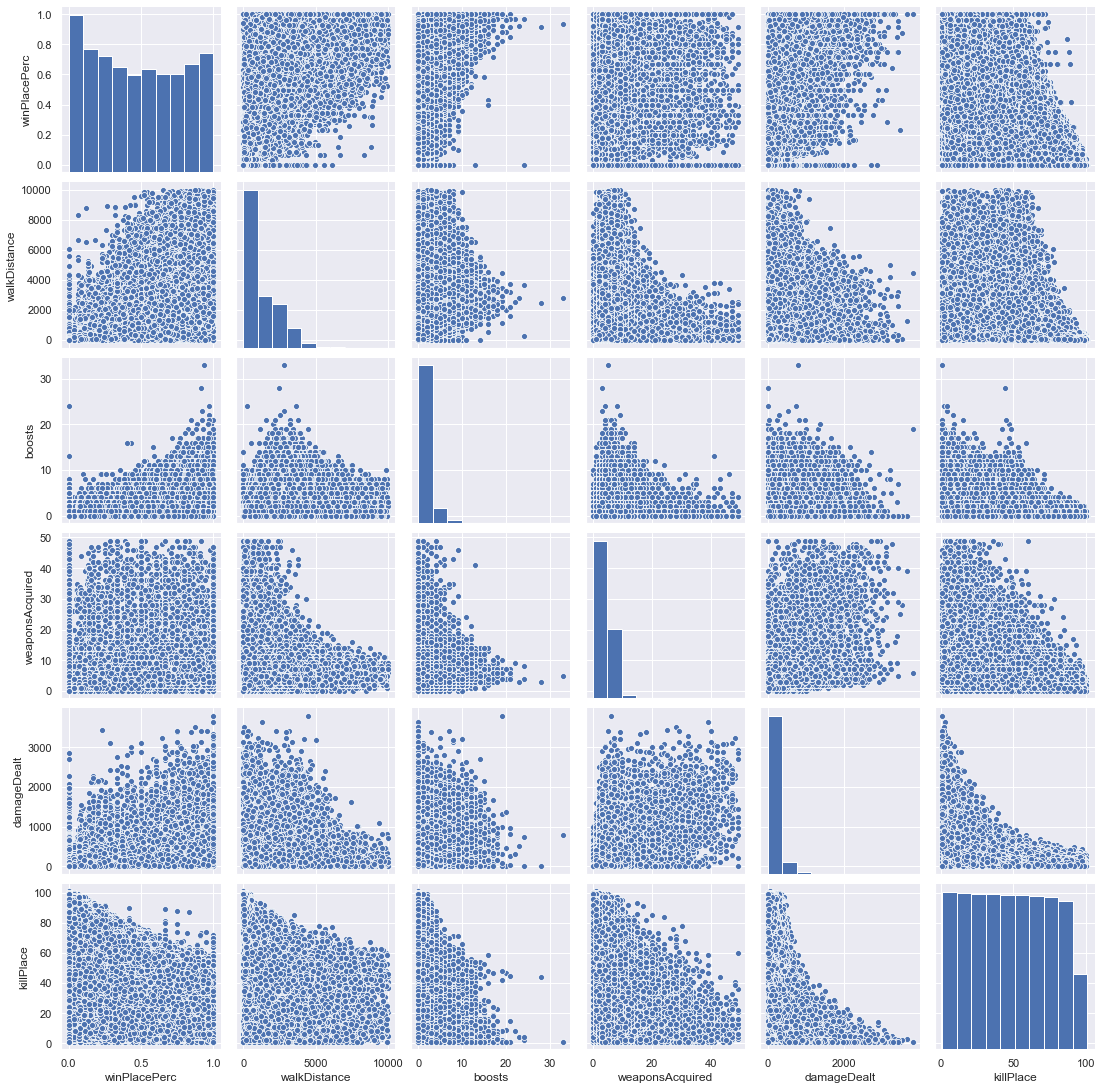

In [63]:
sns.set()
cols = ['winPlacePerc', 'walkDistance', 'boosts', 'weaponsAcquired', 'damageDealt', 'killPlace']
sns.pairplot(df_train[cols], size = 2.5)
plt.show()

In [15]:
def visualization (col, num_bin=10):
    title = col[0].upper() + col[1:]
    f,axes=plt.subplots()
    plt.xlabel(title)
    plt.ylabel('Log Count')
    axes.set_yscale('log')
    df_train.hist(column=col,ax=axes,bins=num_bin)
    plt.title('Histogram of ' + title)
    plt.show()
    
    tmp = df_train[col].value_counts().sort_values(ascending=False)

    print('Min value of ' + title + ' is: ',min(tmp.index))
    print('Max value of ' + title + ' is: ',max(tmp.index))

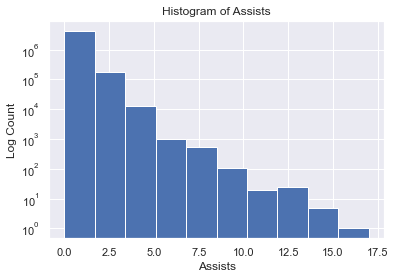

Min value of Assists is:  0
Max value of Assists is:  17


In [65]:

visualization('assists')

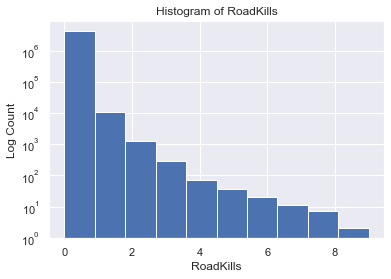

Min value of RoadKills is:  0
Max value of RoadKills is:  9


In [64]:
visualization('roadKills')

In [67]:
# # since, most of the players have kills from  0 to 10 
# so to remove the outliers from my data, we drop all the players who have more than 10 roadkills.
 # drop all the road kills above 10.


#test

df_train.drop(df_train[df_train['roadKills']>=10].index,inplace=True)

#test 

df_test.drop(df_test[df_test['roadKills']>=10].index,inplace=True)

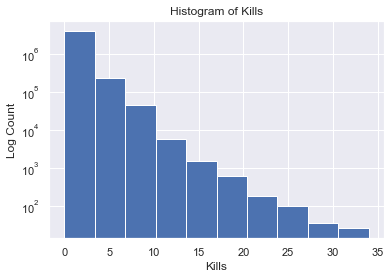

Min value of Kills is:  0
Max value of Kills is:  34


In [68]:
visualization('kills')

In [72]:
# dropping the outliers.

#train
df_train.drop(df_train[df_train['kills']>=35].index,inplace=True)

#test

df_test.drop(df_test[df_test['kills']>=35].index,inplace=True)

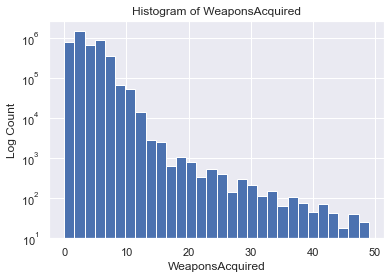

Min value of WeaponsAcquired is:  0
Max value of WeaponsAcquired is:  49


In [73]:
visualization('weaponsAcquired',num_bin=30)

In [74]:

# removing the outliers.

#train
df_train.drop(df_train[df_train.weaponsAcquired>=50].index,inplace=True)

#test
df_test.drop(df_test[df_test.weaponsAcquired>=50].index,inplace=True)

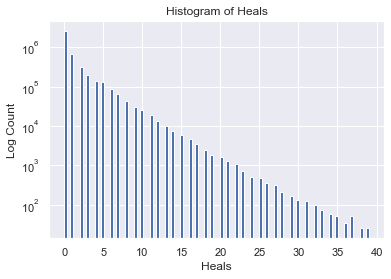

Min value of Heals is:  0
Max value of Heals is:  39


In [75]:
visualization('heals', num_bin=100)

In [76]:
# removing the outliers.

#train
df_train.drop(df_train[df_train.heals>=40].index,inplace=True)

#test

df_test.drop(df_test[df_test.heals>=40].index,inplace=True)

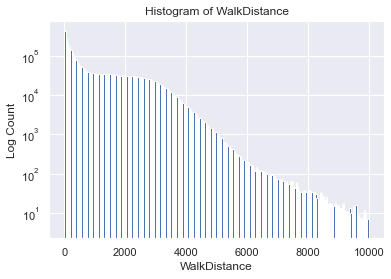

Min value of WalkDistance is:  0.0
Max value of WalkDistance is:  9992.0


In [77]:
visualization('walkDistance',num_bin=250)

In [78]:
#Removing the outliers

#train
df_train.drop(df_train[df_train['walkDistance']>=10000].index,inplace=True)


#test
df_test.drop(df_test[df_test['walkDistance']>=10000].index,inplace=True)

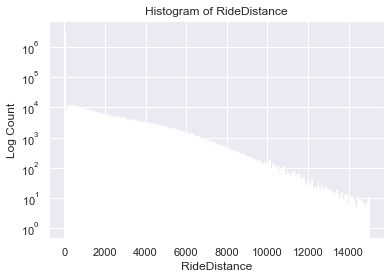

Min value of RideDistance is:  0.0
Max value of RideDistance is:  14992.0


In [79]:
visualization('rideDistance',num_bin=500)

In [80]:
#Removing the outliers.

#test

df_train.drop(df_train[df_train.rideDistance >=15000].index, inplace=True)

#test

df_test.drop(df_test[df_test.rideDistance >=15000].index, inplace=True)

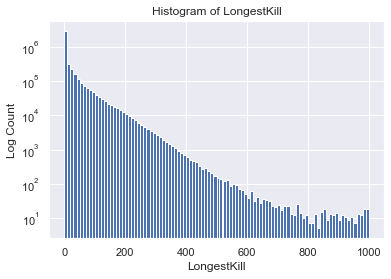

Min value of LongestKill is:  0.0
Max value of LongestKill is:  999.5


In [81]:
visualization('longestKill', num_bin=100) 

In [82]:
# drop outliers.      


#train
df_train.drop(df_train[df_train['longestKill']>=1000].index,inplace=True)

#test

df_test.drop(df_test[df_test['longestKill']>=1000].index,inplace=True)

In [83]:

df_train.shape

(4445866, 44)

So the initial shape is (4446965, 29)And After removing the outliers the new shape is (4445866, -) Something around 1100 rows have been removed until now. Which is nothing compared to the number of rows we have.

In [25]:

# Creating a dummy variable for categorical variable present in our data set.
#matchType
#train

df_train=pd.get_dummies(df_train,columns=['matchType'])

#test

df_test=pd.get_dummies(df_test,columns=['matchType'])

Correlation Analysis

We try to drp unnecessary columns. Then we fit the necessary columns and figure out the correlation between them.

In [109]:
#Correlation Analysis
cols_to_drop = ['Id','matchId','groupId','matchType']
cols_to_fit = [col for col in df_train.columns if col not in cols_to_drop]
corr = df_train[cols_to_fit].corr()

In [110]:
corr=df_train.corr()
corr

,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,killPoints,kills,killStreaks,longestKill,matchDuration,maxPlace,numGroups,rankPoints,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc,matchType_crashfpp,matchType_crashtpp,matchType_duo,matchType_duo-fpp,matchType_flarefpp,matchType_flaretpp,matchType_normal-duo,matchType_normal-duo-fpp,matchType_normal-solo,matchType_normal-solo-fpp,matchType_normal-squad,matchType_normal-squad-fpp,matchType_solo,matchType_solo-fpp,matchType_squad,matchType_squad-fpp
assists,1.000000,0.309098,0.402612,0.301723,0.195061,0.229771,-0.290429,0.039325,0.314429,0.242700,0.261436,-0.019697,-0.147839,-0.146689,-0.016516,0.199098,0.112346,0.012297,0.023556,0.005803,0.058221,0.292163,0.237816,0.024151,0.300263,-0.002685,0.000141,-0.009337,-0.016252,0.000975,0.002052,0.010006,0.020334,0.019435,0.044124,0.020450,0.098546,-0.062645,-0.111114,0.038914,0.073999
boosts,0.309098,1.000000,0.525723,0.359476,0.337836,0.537214,-0.554942,0.008335,0.506656,0.405760,0.423970,0.071987,-0.013809,-0.013051,0.023211,0.253258,0.331449,0.035650,0.107986,0.013113,0.087397,0.641074,0.413224,-0.007658,0.634292,0.000539,-0.000008,0.004264,-0.009035,0.001552,0.003568,-0.000057,0.012094,-0.001333,-0.003903,-0.001167,0.011647,-0.004972,-0.010451,0.016195,0.000530
damageDealt,0.402612,0.525723,1.000000,0.740124,0.611190,0.345732,-0.680808,0.050359,0.887328,0.705255,0.566092,-0.006896,-0.040107,-0.039409,-0.001494,0.258719,0.143509,0.052200,0.037113,0.015187,0.081807,0.401933,0.347647,0.017904,0.442809,-0.009019,-0.001543,-0.006960,0.005221,0.000587,-0.000313,0.011620,0.022652,0.030354,0.058023,0.021814,0.091712,-0.021908,-0.025480,-0.007165,0.014230
DBNOs,0.301723,0.359476,0.740124,1.000000,0.473133,0.267007,-0.555895,0.042676,0.713232,0.647641,0.452170,-0.014403,-0.267899,-0.265980,-0.003442,0.301002,0.104029,0.037006,0.017388,0.069572,0.060329,0.285624,0.221072,0.011111,0.280290,-0.006753,-0.001421,-0.011405,-0.013738,0.002593,0.004134,0.009800,0.006038,-0.004846,-0.010858,0.009821,0.051112,-0.118693,-0.212942,0.069431,0.151790
headshotKills,0.195061,0.337836,0.611190,0.473133,1.000000,0.201747,-0.473179,0.024336,0.672306,0.513850,0.449769,-0.017565,0.010011,0.010244,0.005119,0.151562,0.078260,0.013516,0.028907,0.008412,0.039619,0.254032,0.213974,0.005072,0.279603,-0.009515,-0.002600,-0.006423,-0.001320,-0.000463,-0.001371,0.007527,0.013097,0.021880,0.044222,0.019298,0.052461,-0.000916,0.015590,-0.009781,-0.007899
heals,0.229771,0.537214,0.345732,0.267007,0.201747,1.000000,-0.387430,-0.002634,0.314558,0.271627,0.264631,0.108908,-0.065359,-0.064781,0.019262,0.237680,0.300353,0.024899,0.079785,0.035443,0.063061,0.432123,0.313519,-0.011112,0.429124,-0.002273,-0.001464,-0.003233,-0.008101,0.002227,0.004205,0.003299,0.012115,0.002997,0.005612,0.003213,0.037141,-0.027858,-0.050431,0.021093,0.032468
killPlace,-0.290429,-0.554942,-0.680808,-0.555895,-0.473179,-0.387430,1.000000,-0.023282,-0.735524,-0.810913,-0.541634,-0.005716,0.016751,0.018737,-0.014813,-0.269897,-0.237988,-0.058089,-0.089391,-0.037775,-0.073588,-0.591196,-0.496329,-0.002406,-0.719093,-0.003632,-0.003056,-0.001928,0.000731,-0.002795,-0.002989,-0.008922,-0.028075,-0.011279,-0.024101,-0.009161,-0.042810,-0.010710,0.005759,0.001303,0.009394
killPoints,0.039325,0.008335,0.050359,0.042676,0.024336,-0.002634,-0.023282,1.000000,0.036659,0.037144,0.014140,-0.099595,-0.044842,-0.042404,-0.975555,0.012051,-0.029931,-0.004492,-0.004578,-0.039737,-0.009700,0.004685,-0.003983,0.983417,0.012901,-0.030282,-0.007352,-0.027157,-0.016589,-0.010228,-0.014818,0.001621,0.009453,0.002186,-0.001005,-0.003647,-0.007998,-0.031999,-0.026221,-0.005398,0.066499
kills,0.314429,0.506656,0.887328,0.713232,0.672306,0.314558,-0.735524,0.036659,1.000000,0.805901,0.606420,-0.031039,-0.003922,-0.003054,0.008226,0.255582,0.117172,0.063495,0.039611,0.017282,0.080783,0.379069,0.329597,0.007032,0.422786,-0.003555,-0.000249

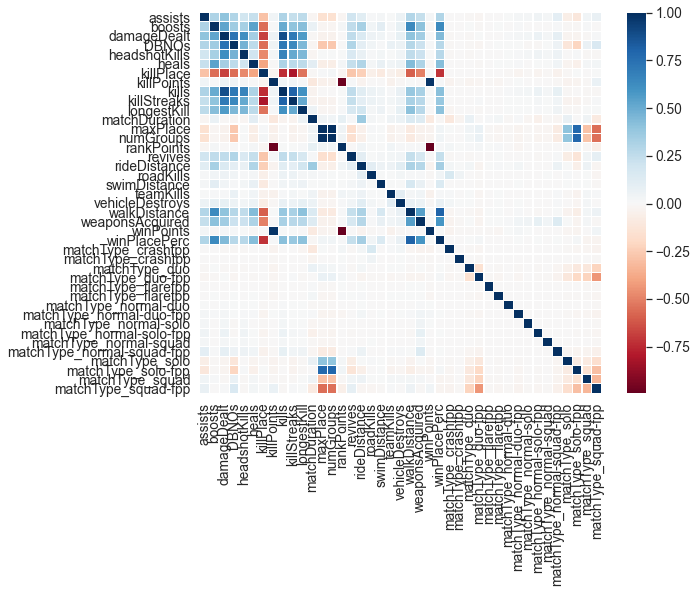

In [105]:
plt.figure(figsize=(9,7))
sns.heatmap(corr,xticklabels=corr.columns.values,yticklabels=corr.columns.values,linecolor='white',linewidths=0.1,cmap='RdBu')
plt.show()

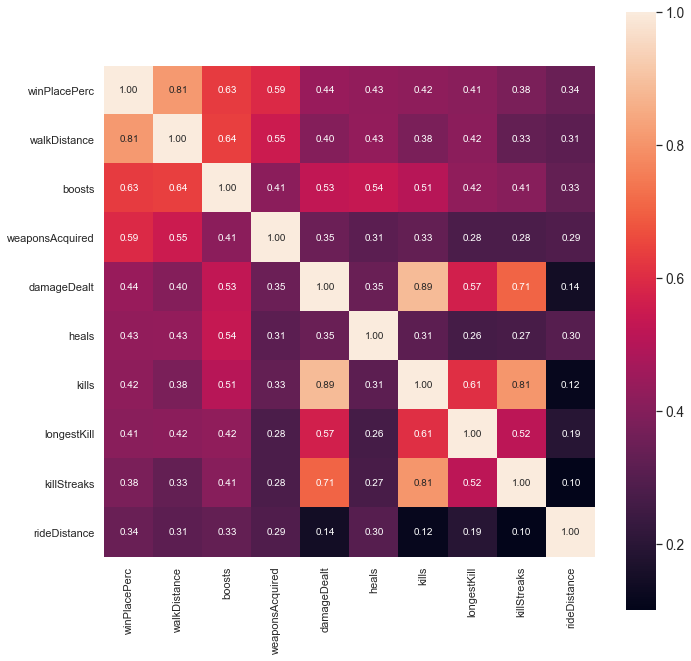

In [84]:
k = 10 #number of variables for heatmap
f,ax = plt.subplots(figsize=(11, 11))
cols = df_train.corr().nlargest(k, 'winPlacePerc')['winPlacePerc'].index
cm = np.corrcoef(df_train[cols].values.T)
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

<AxesSubplot:title={'center':'Correlation B/w Winning % and other Independent Variable'}>

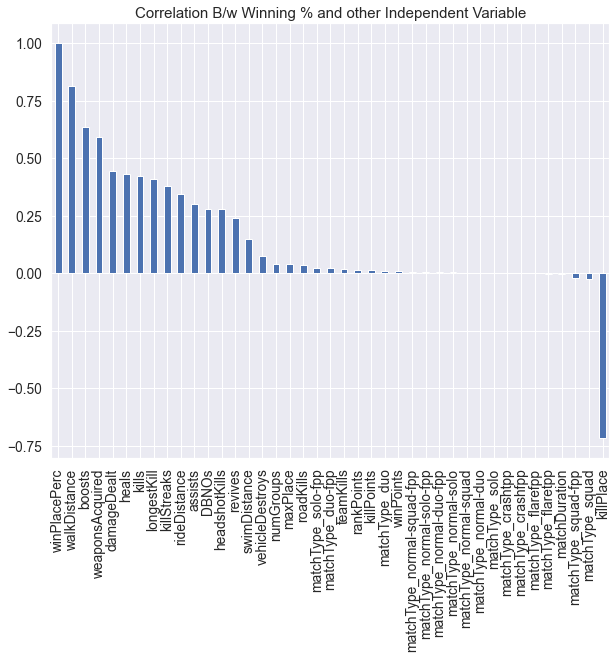

In [85]:
plt.title('Correlation B/w Winning % and other Independent Variable')
df_train.corr()['winPlacePerc'].sort_values(ascending=False).plot(kind='bar',figsize=(10,8))

Hyperparameter turning

In [28]:
t = df_train
t =t.drop(['Id','groupId','matchId',],axis=1)
y = t['winPlacePerc']
X = t.drop(['winPlacePerc'],axis=1)
X_test = df_test.drop(['Id','groupId','matchId'],axis=1)

In [29]:
#splitting the data into training and testing by using train_test_split
X_train, X_val, y_train, y_val = train_test_split(X, y, train_size=0.7)
len(X_train)

#del train,test,X,y

#X_train = X
#y_train = y
gc.collect()

20234

Model LightGBM

In [30]:

import lightgbm as lgbm

In [31]:
def calculate_error(cl,name):
  print(name)
  y_pre = cl.predict(X_val)
  print('Mean Absolute Error is {:.5f}'.format(mean_absolute_error(y_val,y_pre)))
  print('R2 score is {:.2%}'.format(r2_score(y_val, cl.predict(X_val))))

In [32]:
params = {"objective" : "regression", "metric" : "mae", 'n_estimators':20000, 
              'early_stopping_rounds':200, "num_leaves" : 31, "learning_rate" : 0.05, 
              "bagging_fraction" : 0.7, "bagging_seed" : 0, "num_threads" : 4,
              "colsample_bytree" : 0.7
             }
lgbTrain = lgbm.Dataset(X_train, label=y_train)
lgbVal = lgbm.Dataset(X_val, label=y_val)
model = lgbm.train(params,lgbTrain,valid_sets=[lgbTrain, lgbVal],
                      early_stopping_rounds=200, verbose_eval=1000)

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.357788 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2824
[LightGBM] [Info] Number of data points in the train set: 3112106, number of used features: 40
[LightGBM] [Info] Start training from score 0.472643
Training until validation scores don't improve for 200 rounds
[1000]	training's l1: 0.0565582	valid_1's l1: 0.0568018
[2000]	training's l1: 0.0558564	valid_1's l1: 0.0563178
[3000]	training's l1: 0.0553707	valid_1's l1: 0.0560328
[4000]	training's l1: 0.0549788	valid_1's l1: 0.055822
[5000]	training's l1: 0.0546223	valid_1's l1: 0.0556383
[6000]	training's l1: 0.054304	valid_1's l1: 0.0554903
[7000]	training's l1: 0.054025	valid_1's l1: 0.0553842
[8000]	training's l1: 0.0537461	valid_1's l1: 0.0552648
[9000]	training's l1: 0.0535014	valid_1's l1: 0.0551736
[10000]	training's l1: 0.0

In [33]:
calculate_error(model,"LGBM")

LGBM
Mean Absolute Error is 0.05456
R2 score is 93.75%


In [34]:

y_predict = model.predict(X_test)

In [35]:
y_predict[y_predict > 1] = 1
y_predict[y_predict < 0] = 0
df_test['winPlacePerc'] = y_predict
submission = df_test[['Id', 'winPlacePerc']]
submission.to_csv('Finalsubmission.csv', index=False)

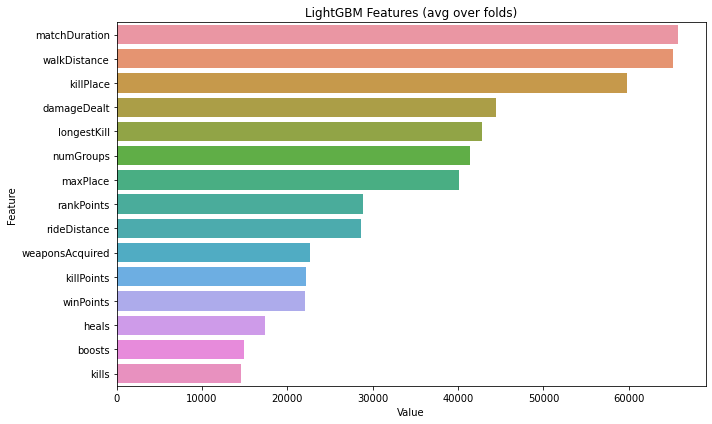

In [36]:

#find which feature importance
cols_to_drop = ['Id', 'groupId', 'matchId', 'winPlacePerc']
cols_to_fit = [col for col in X_train.columns if col not in cols_to_drop]
feature_importance = pd.DataFrame(sorted(zip(model.feature_importance(), cols_to_fit)), columns=['Value','Feature'])
feature_importance = feature_importance.tail(15)


plt.figure(figsize=(10, 6))
sns.barplot(x="Value", y="Feature", data=feature_importance.sort_values(by="Value", ascending=False))
plt.title('LightGBM Features (avg over folds)')
plt.tight_layout()
plt.savefig("lgbmfeatures.png",dpi=500)

In [86]:
def runAllModels(X_train, Y_train):
        
    linear = LinearRegression(copy_X=True)
    linear.fit(X_train,Y_train)
    calculate_error(linear,"linear")

    
    
    GBR = GradientBoostingRegressor(learning_rate=0.8)
    GBR.fit(X_train,Y_train)
    calculate_error(GBR,"GBR")

    forest = RandomForestRegressor(n_estimators=10)
    forest.fit(X_train,Y_train)
    calculate_error(forest,"forest")

    
    
    

In [87]:
runAllModels(X_train,y_train)

linear
Mean Absolute Error is 0.08980
R2 score is 84.01%
GBR
Mean Absolute Error is 0.06215
R2 score is 92.13%
forest
Mean Absolute Error is 0.06061
R2 score is 92.26%
